# Atmo Model Training Notebook

Train an Atmo Model using `usl_models` lib.

In [23]:
%load_ext autoreload
%autoreload 2
import keras
import os, time
import pathlib
from usl_models.atmo_ml.model import AtmoModel
from usl_models.atmo_ml import dataset, visualizer, vars

import logging

logging.getLogger().setLevel(logging.WARNING)
keras.utils.set_random_seed(812)
visualizer.init_plt()

batch_size = 4
filecache_dir = pathlib.Path("/home/shared/climateiq/filecache")
example_keys=[
    ("NYC_Heat_Test/NYC_summer_2000_01p", "2000-05-25"),
    ("NYC_Heat_Test/NYC_summer_2000_01p", "2000-05-26"),
    ("NYC_Heat_Test/NYC_summer_2000_01p", "2000-05-27"),
    ("NYC_Heat_Test/NYC_summer_2000_01p", "2000-05-28"),
    ("PHX_Heat_Test/PHX_summer_2008_25p", "2008-05-25"),
    ("PHX_Heat_Test/PHX_summer_2008_25p", "2008-05-26"),
    ("PHX_Heat_Test/PHX_summer_2008_25p", "2008-05-27"),
    ("PHX_Heat_Test/PHX_summer_2008_25p", "2008-05-28"),
]

# Create training dataset with fused spatiotemporal data
ds_config = dataset.Config(
    output_timesteps=2)
train_ds = dataset.load_dataset_cached(
    filecache_dir,
    example_keys=example_keys,
    config=ds_config,
).batch(batch_size=batch_size)
val_ds = dataset.load_dataset_cached(
    filecache_dir,
    example_keys=example_keys,
    config=ds_config,
    shuffle=False,
).batch(batch_size=batch_size)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
# Initialize the Atmo Model
params = AtmoModel.default_params()
params.update({"output_timesteps": ds_config.output_timesteps, "lstm_units": 32, "batch_size": 4, "lstm_kernel_size":5})
model = AtmoModel(params)
model.summary(expand_nested=True)

Model: "atmo_conv_lstm_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_5 (Sequential)   (None, None, None, 8)     488       
|¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯|
| embedding_5 (Embedding)    (None, None, None, 8)     488      |
¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯
 spatial_cnn (Sequential)    (None, None, None, 128)   252992    
|¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯|
| conv2d_26 (Conv2D)         (None, None, None, 64)    48064    |
|                                                               |
| max_pooling2d_14 (MaxPool  (None, None, None, 64)    0        |
| ing2D)                                                        |
|                                                               |
| conv2d_27 (Conv2D)         (None, None, None, 128)   204928   |
|                                                 

In [25]:
# Train the model
# Create a unique log directory by appending the current timestamp
log_dir = os.path.join("./logs", "run_" + time.strftime("%Y%m%d-%H%M%S"))
print(log_dir)
tb_callback = keras.callbacks.TensorBoard(log_dir=log_dir)
model.fit(train_ds, val_ds, epochs=1000, callbacks=[tb_callback], validation_freq=10)
model.save_model(log_dir + "/model")

./logs/run_20250226-184227
Epoch 1/1000


2025-02-26 18:42:32.862624: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inatmo_conv_lstm_5/conv_lstm/conv_lstm2d_4/while/body/_1/atmo_conv_lstm_5/conv_lstm/conv_lstm2d_4/while/dropout_7/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


1/1 [==============================] - 39s 39s/step - loss: 0.1607 - mean_absolute_error: 0.3057 - root_mean_squared_error: 0.4008 - mean_absolute_percentage_error: 2202.1013 - nrmse: 0.4008 - ssim_metric: 0.0453 - psnr_metric: 4.0253 - mse_RH2: 0.1827 - mse_T2: 0.2117 - mse_WSPD_WDIR10: 0.0015 - mse_WSPD_WDIR10_COS: 0.1875 - mse_WSPD_WDIR10_SIN: 0.2198
Epoch 2/1000
1/1 [==============================] - 1s 615ms/step - loss: 0.1388 - mean_absolute_error: 0.2748 - root_mean_squared_error: 0.3726 - mean_absolute_percentage_error: 83545.0859 - nrmse: 0.3726 - ssim_metric: 0.2244 - psnr_metric: 9.2250 - mse_RH2: 0.1487 - mse_T2: 0.0258 - mse_WSPD_WDIR10: 0.0195 - mse_WSPD_WDIR10_COS: 0.2802 - mse_WSPD_WDIR10_SIN: 0.2200
Epoch 3/1000
1/1 [==============================] - 1s 614ms/step - loss: 0.1114 - mean_absolute_error: 0.2218 - root_mean_squared_error: 0.3337 - mean_absolute_percentage_error: 2461.9749 - nrmse: 0.3337 - ssim_metric: 0.3122 - psnr_metric: 9.7631 - mse_RH2: 0.0883 - mse_

INFO:tensorflow:Assets written to: ./logs/run_20250226-184227/model/assets


/home/elhajjas/climateiq-cnn-6/usl_models/usl_models/atmo_ml/visualizer.py:32: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, axs = plt.subplots(1, T, figsize=(2 * (T + 0.2), 2), sharey=True)


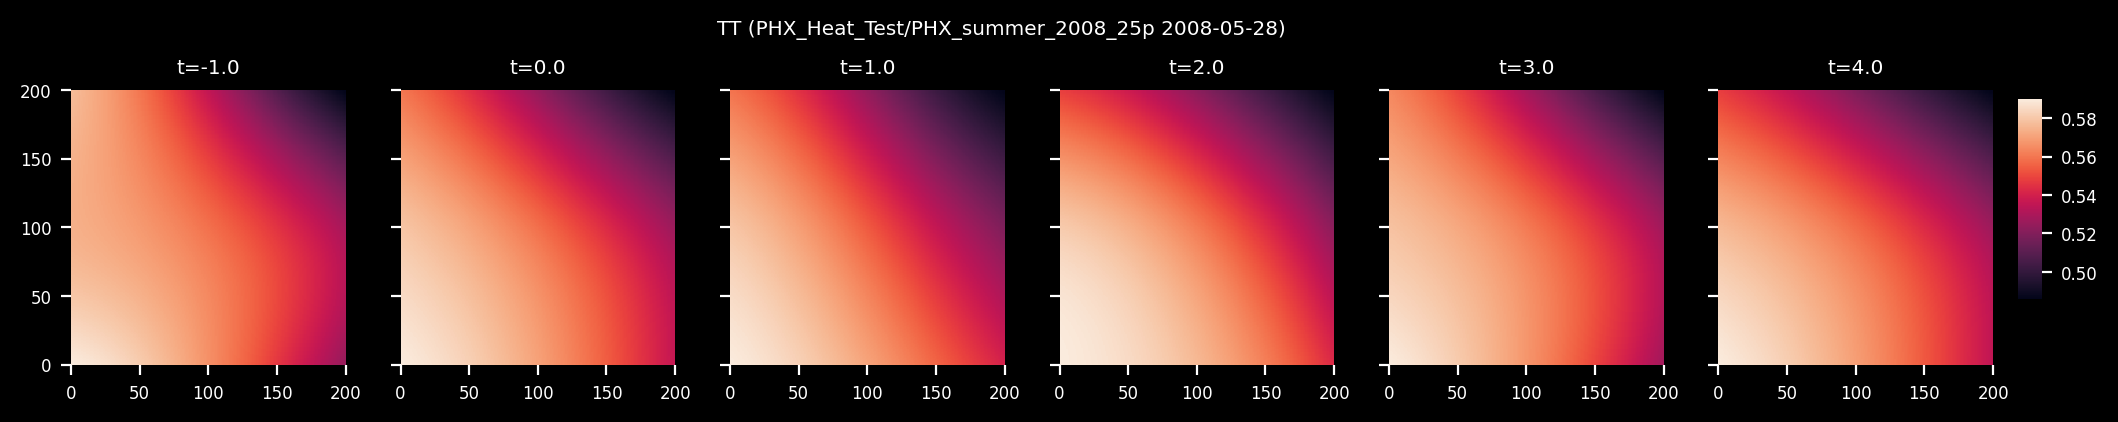

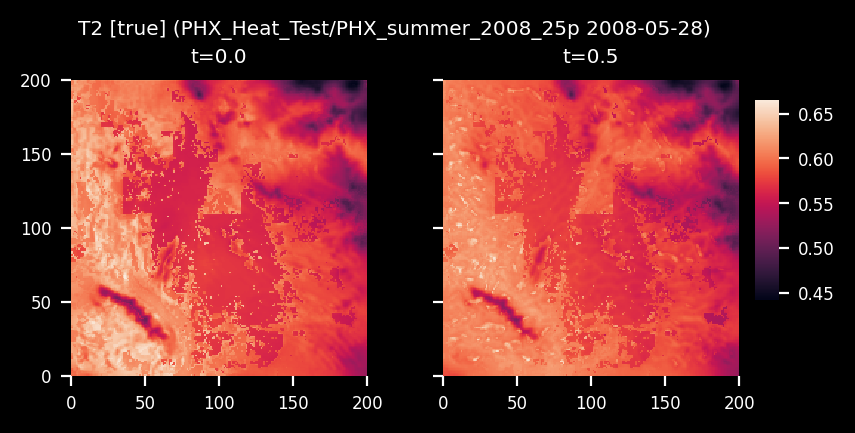

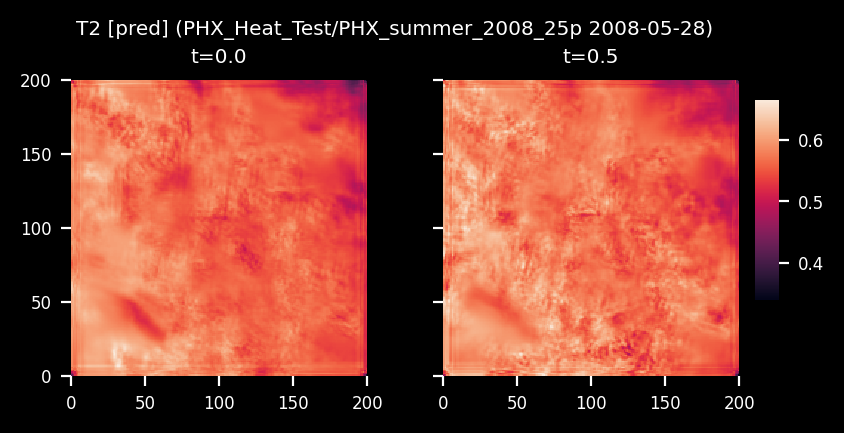

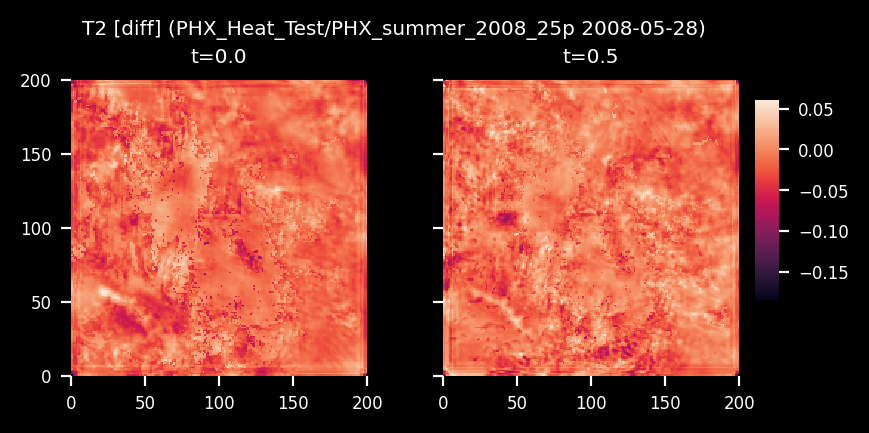

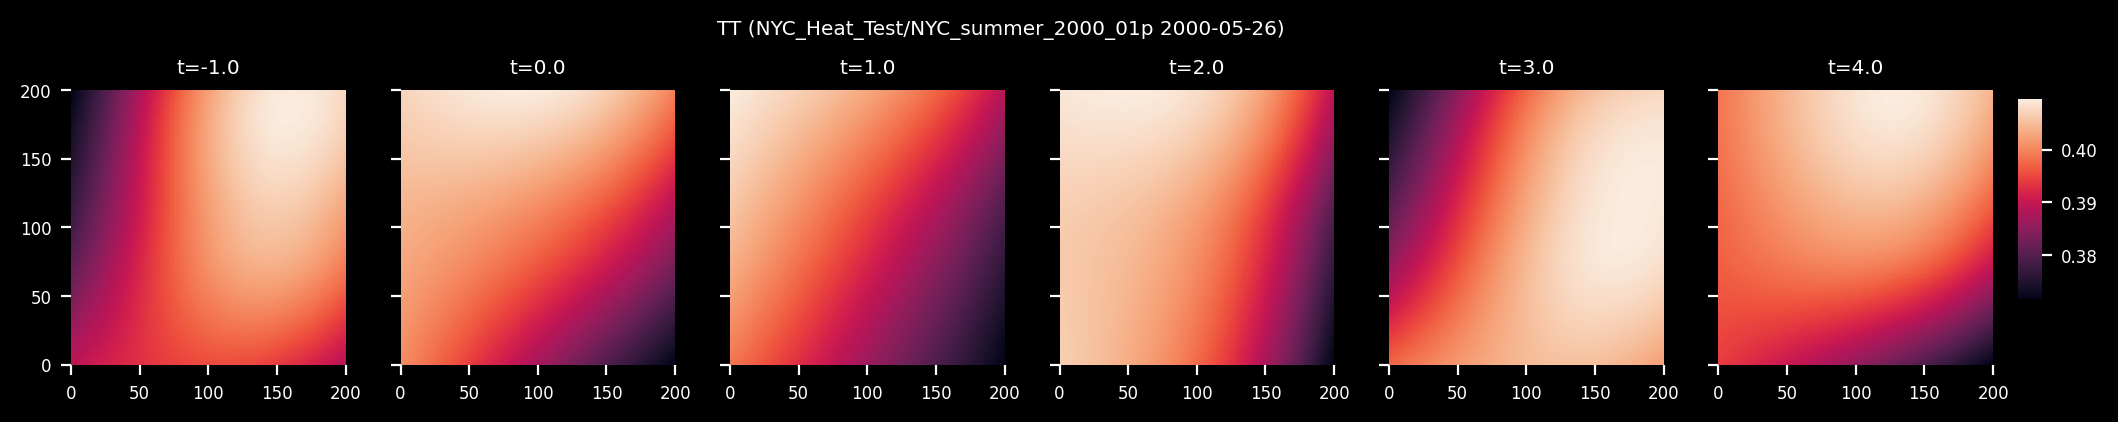

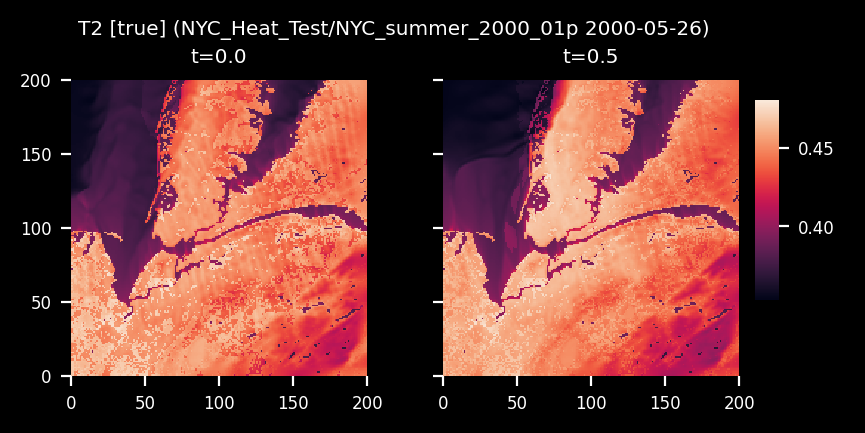

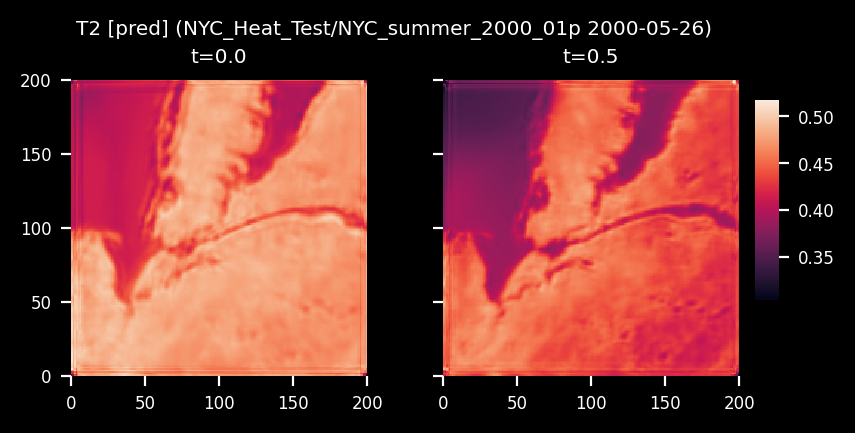

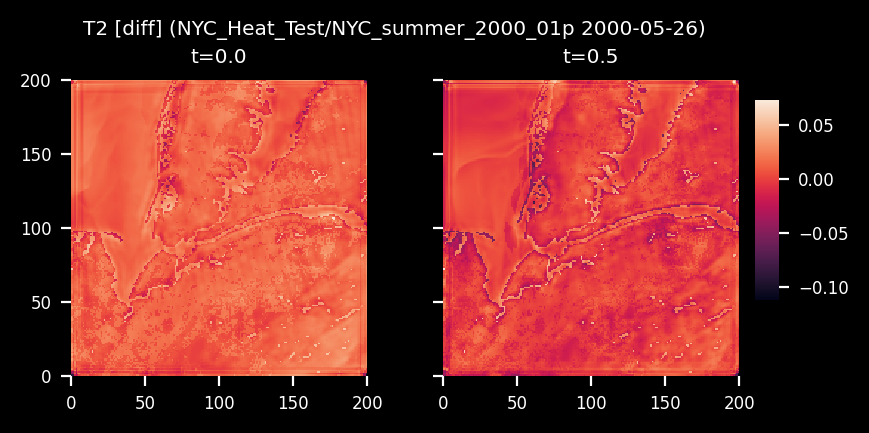

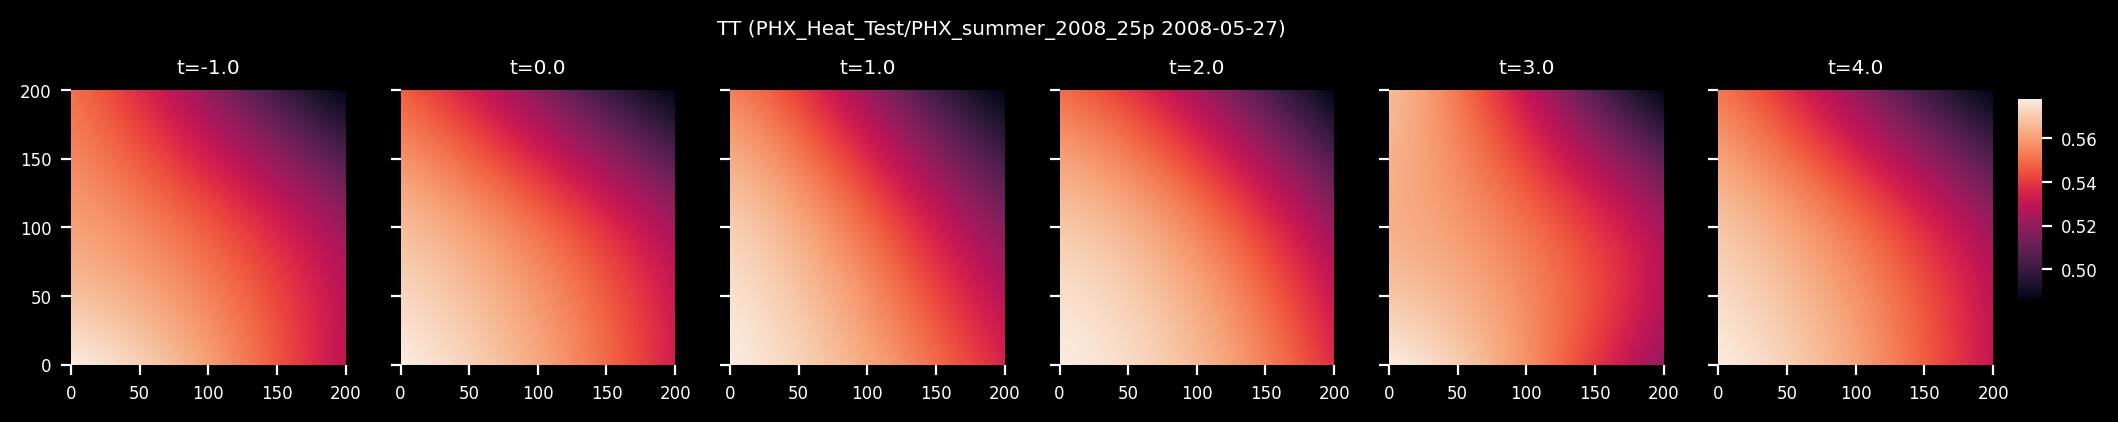

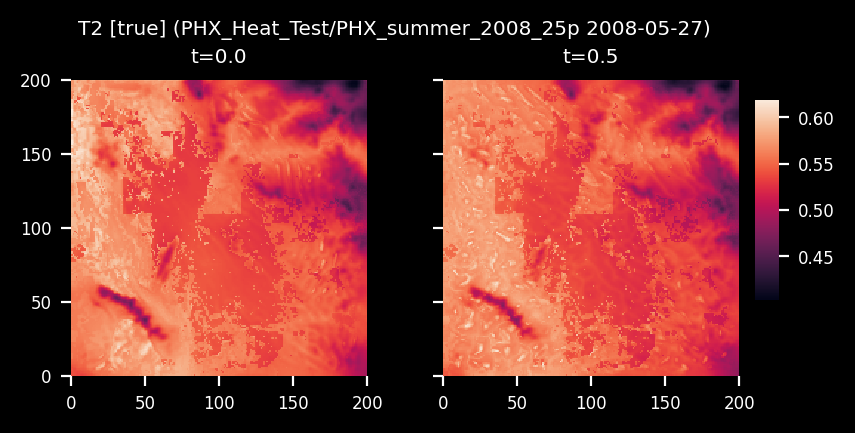

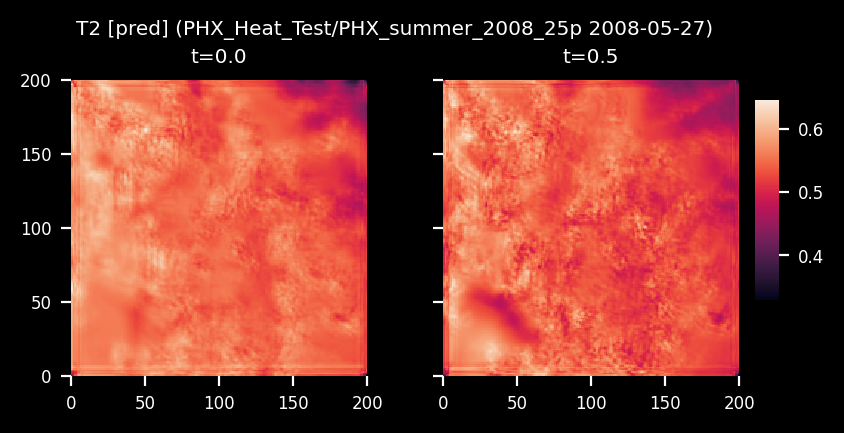

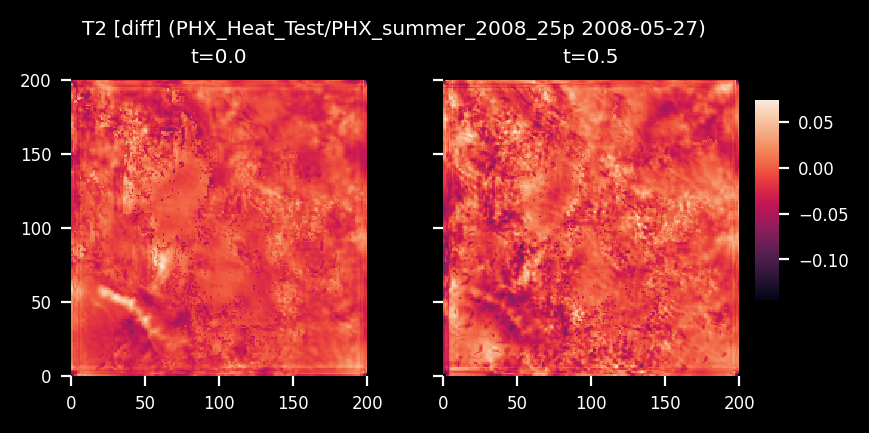

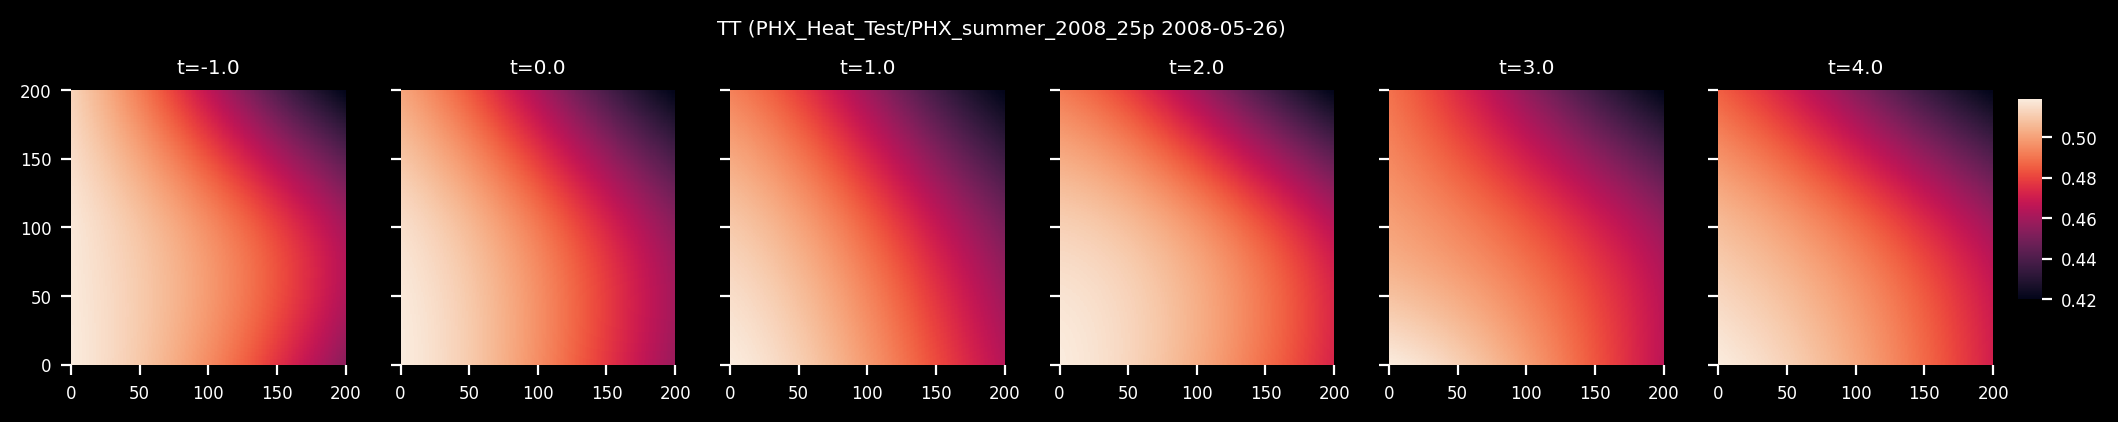

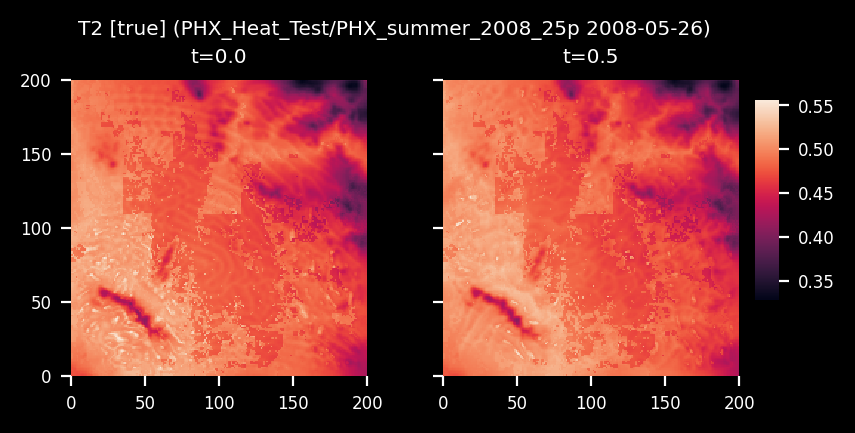

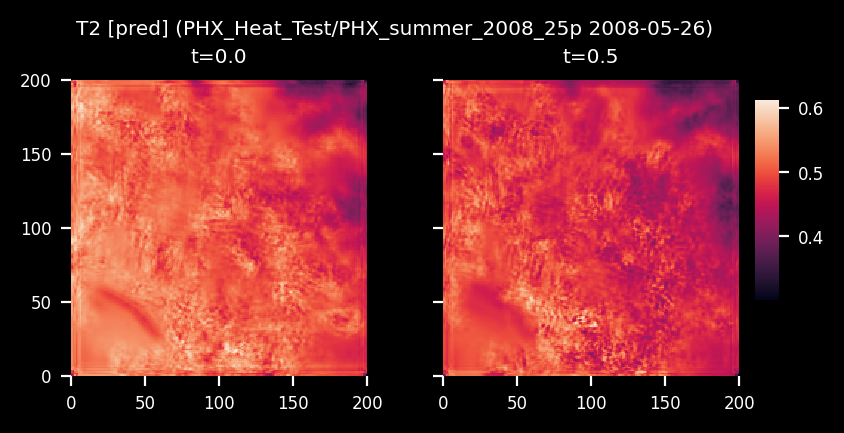

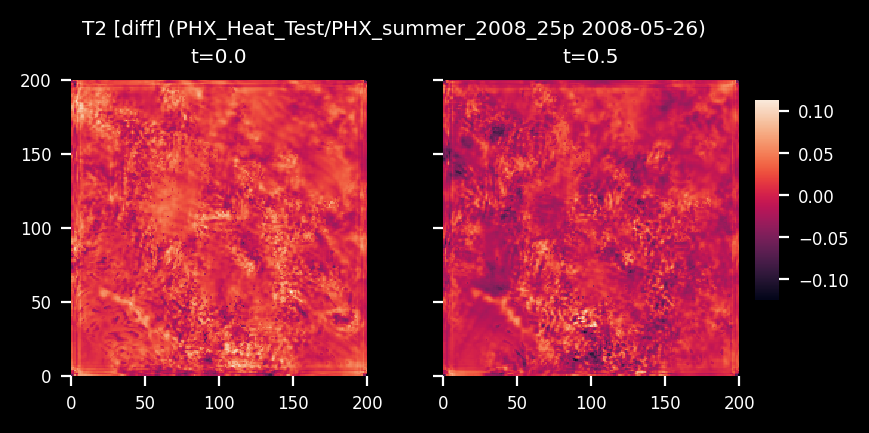

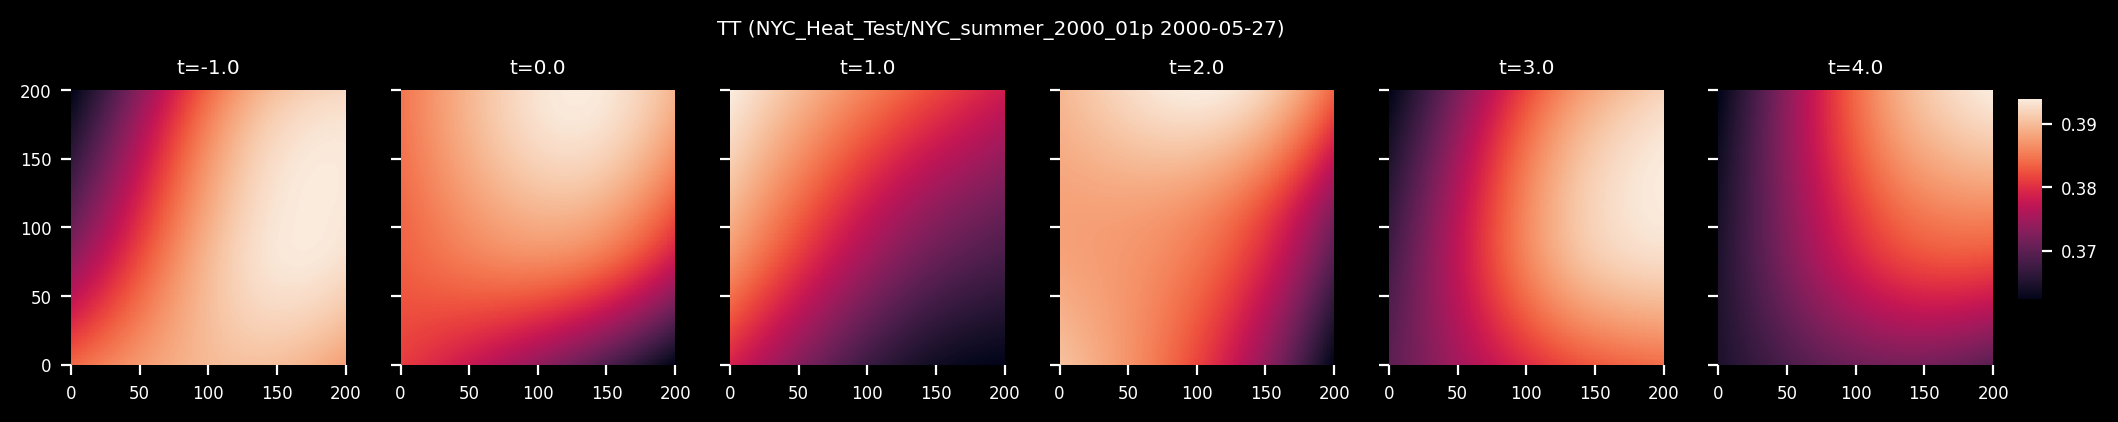

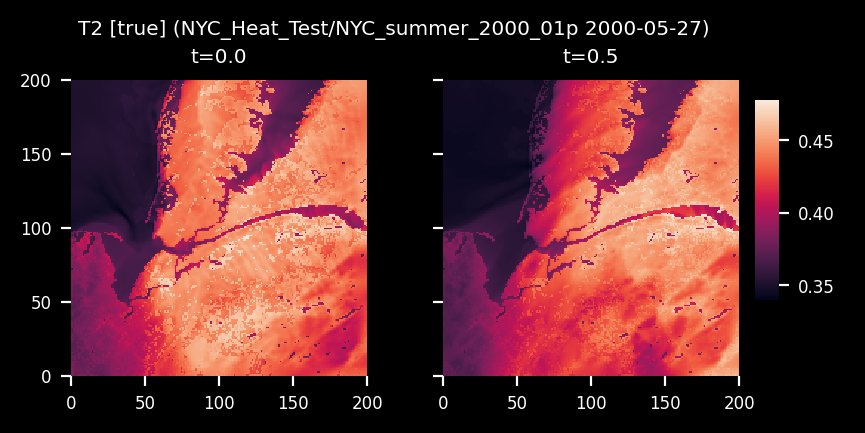

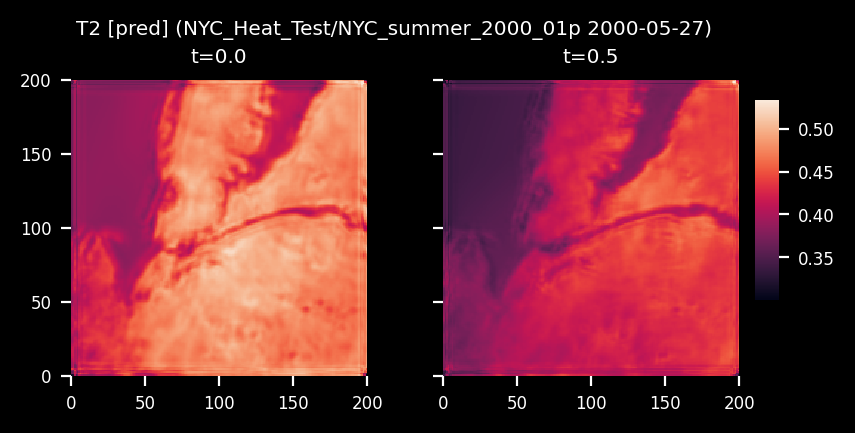

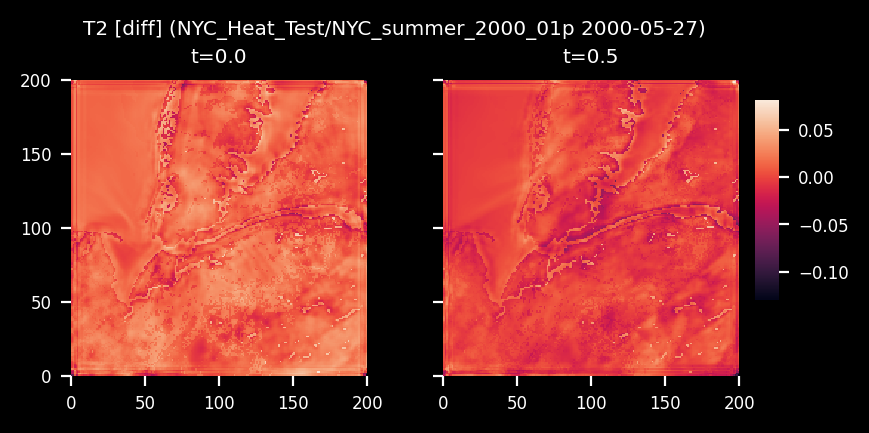

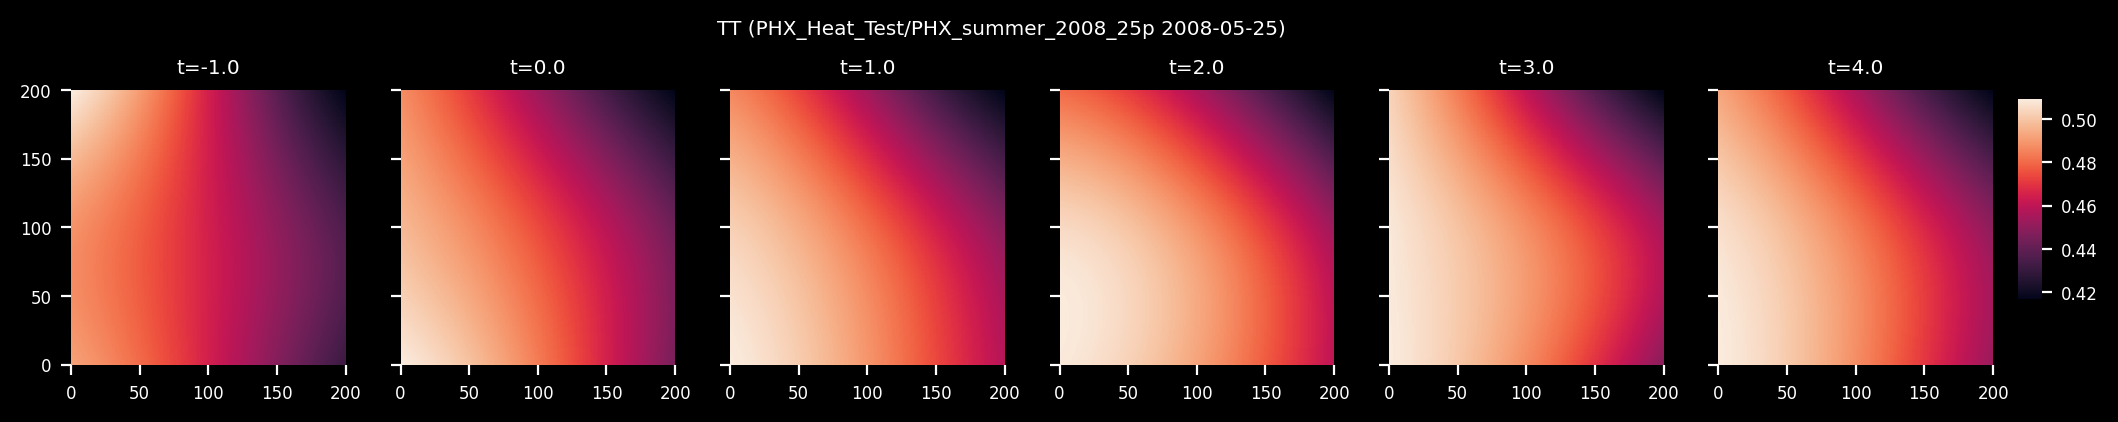

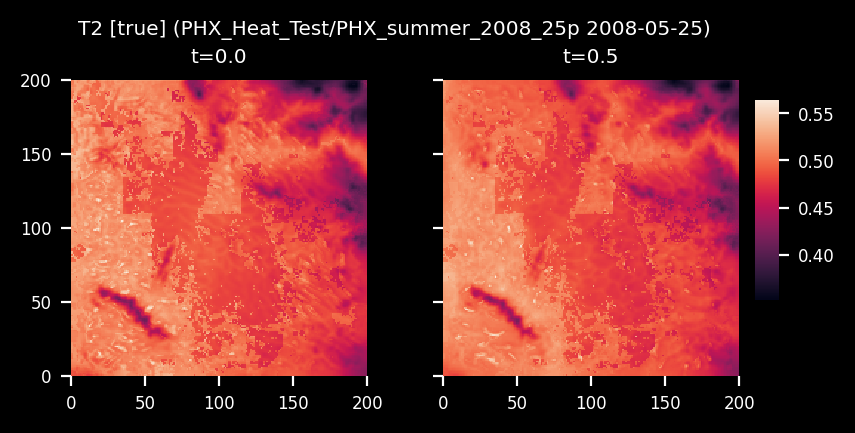

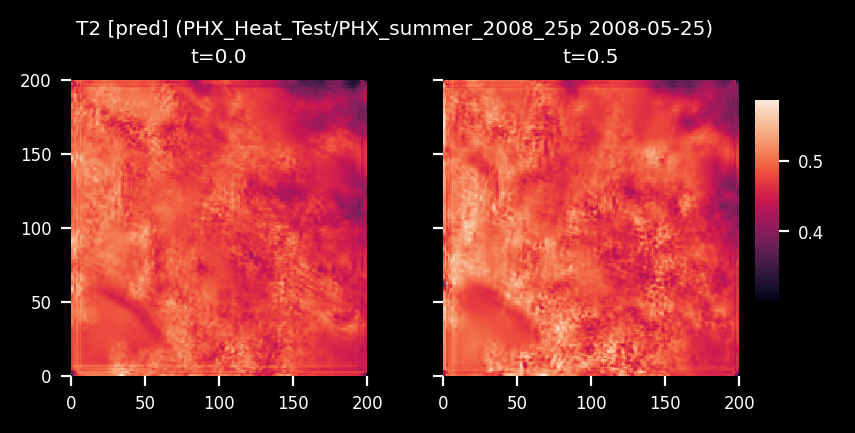

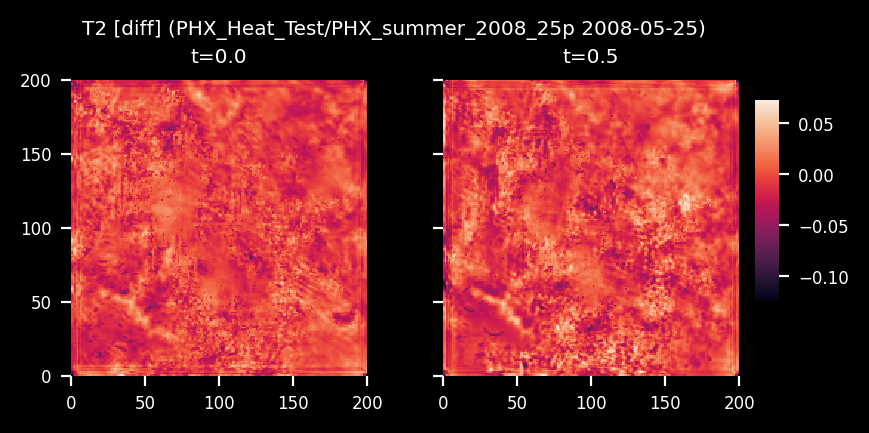

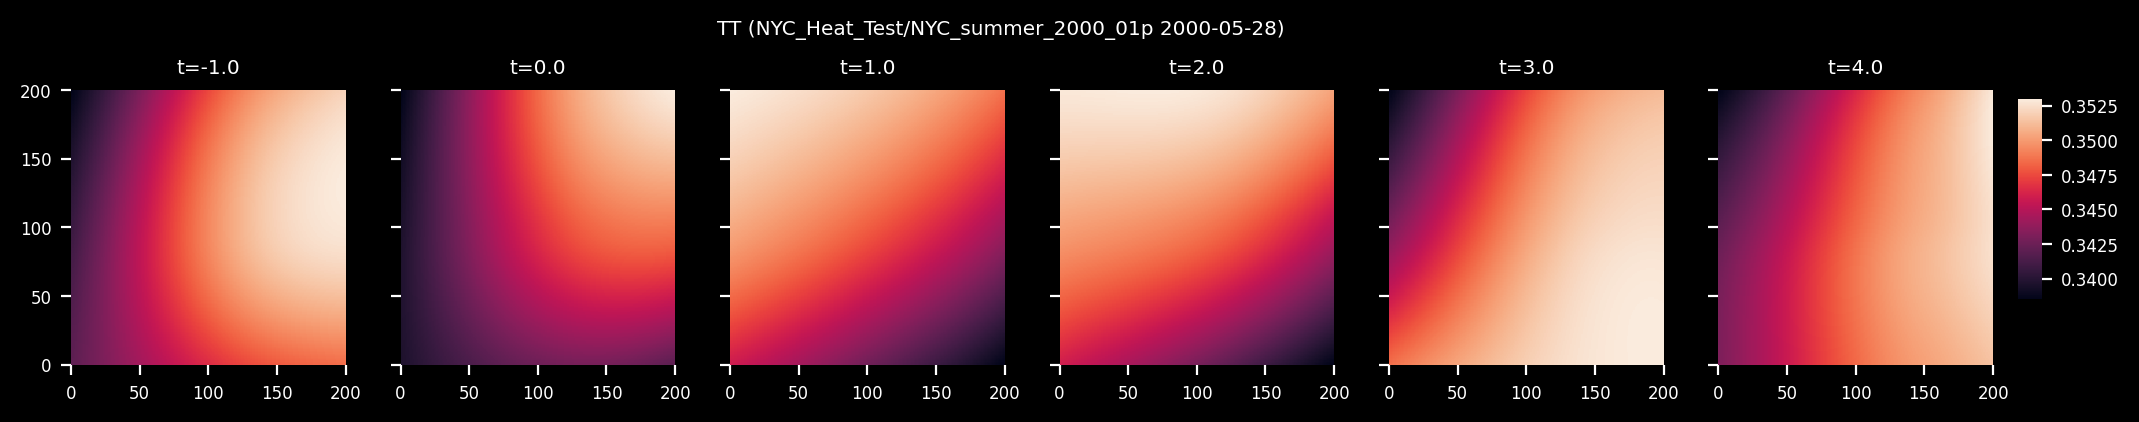

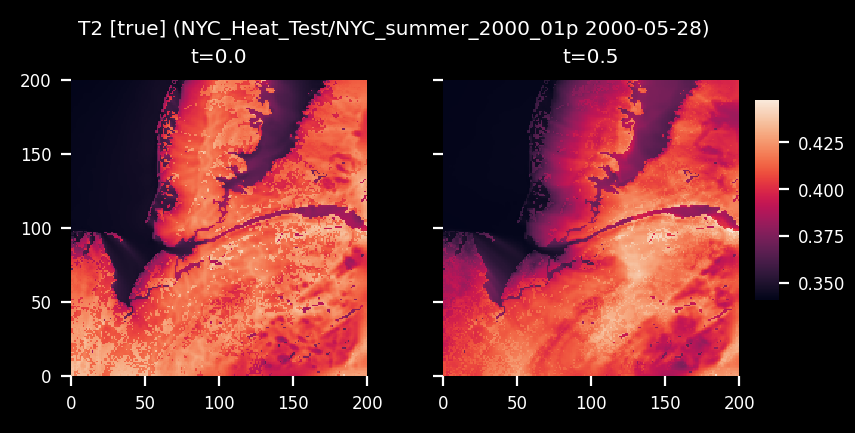

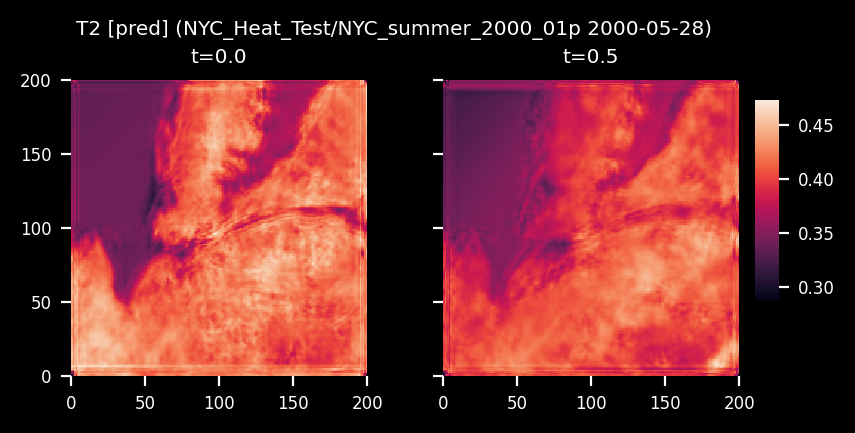

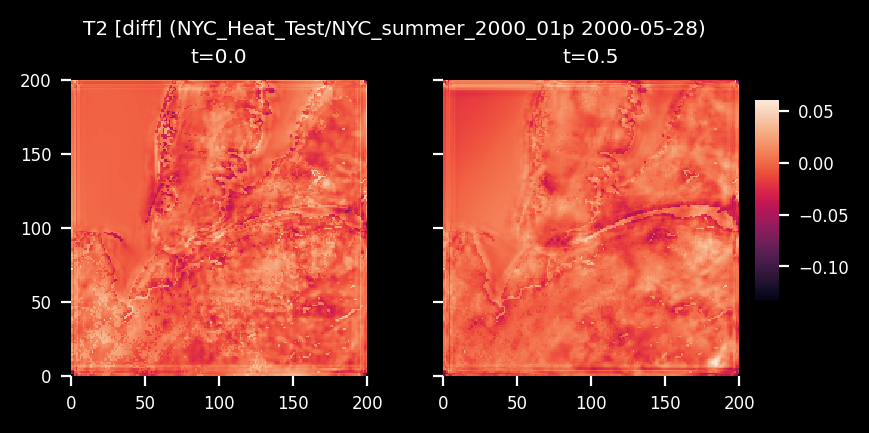

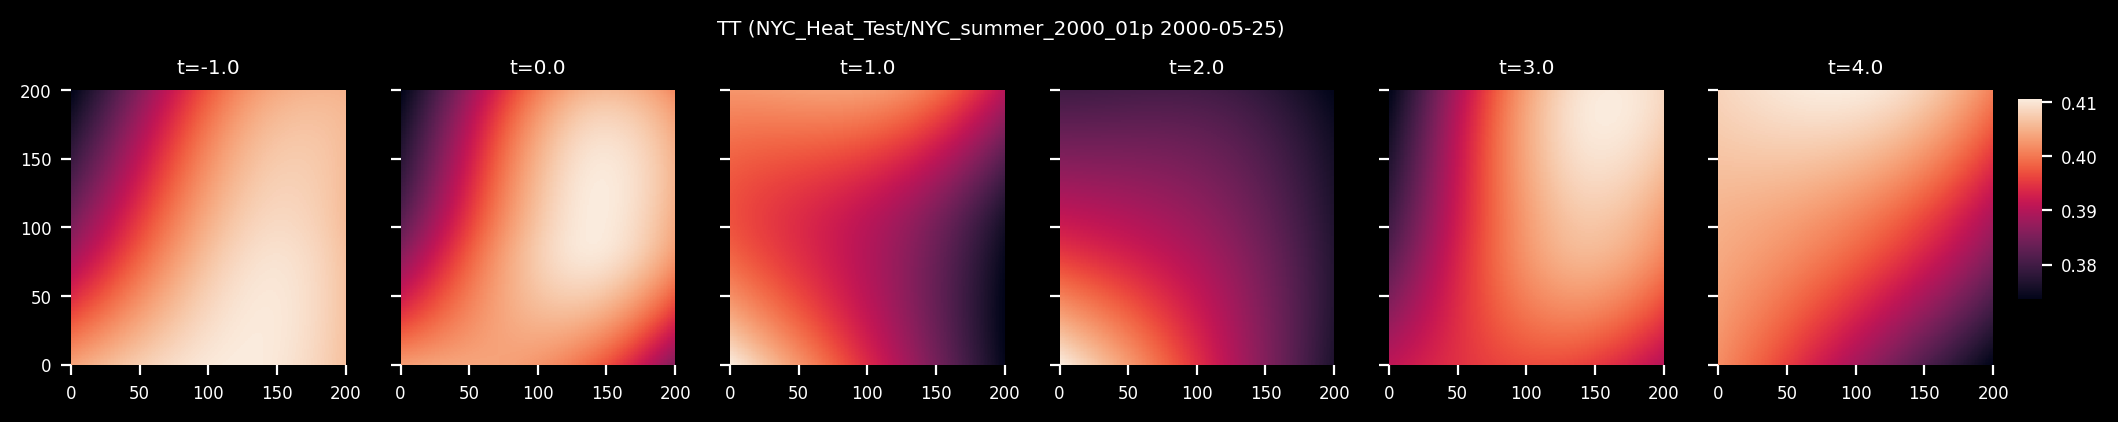

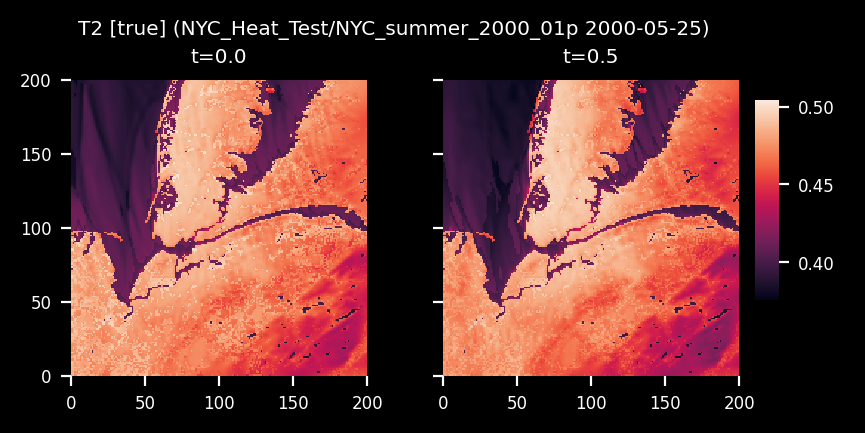

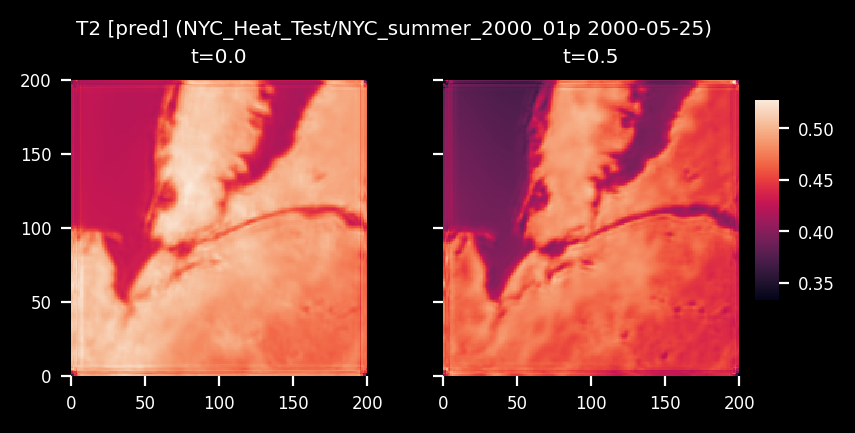

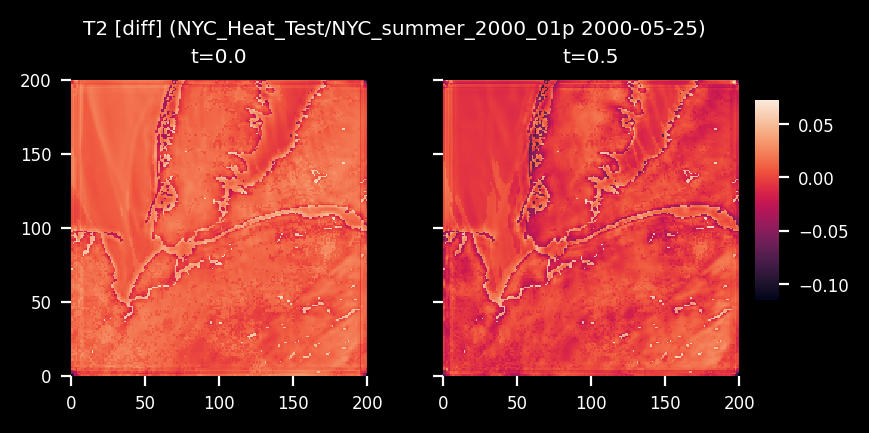

In [26]:
# Plot results
input_batch, label_batch = next(iter(val_ds))
pred_batch = model.call(input_batch)

for fig in visualizer.plot_batch(
    input_batch=input_batch,
    label_batch=label_batch,
    pred_batch=pred_batch,
    st_var=vars.Spatiotemporal.TT,
    sto_var=vars.SpatiotemporalOutput.T2,
    max_examples=None,
):
    fig.show()